In [79]:
import xarray as xr
import requests
import netCDF4
import boto3
from itertools import product
from subprocess import Popen, PIPE
from botocore import UNSIGNED
from botocore.client import Config
import matplotlib.pyplot as plt
%matplotlib inline

In [62]:
#!conda install xarray requests netCDF4 boto3 -c conda-forge -y
#Need sudo password for installation
#!curl https://rclone.org/install.sh | sudo bash -s beta

In [63]:
bucket_name = 'noaa-goes16'
product_name = 'ABI-L1b-RadF'
year = 2019
day_of_year = 200
hour = 12
band = 7
mode = 6

In [64]:
def get_s3_keys(bucket, prefix = ''):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    """
    s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    kwargs = {'Bucket': bucket}

    if isinstance(prefix, str):
        kwargs['Prefix'] = prefix

    while True:
        resp = s3.list_objects_v2(**kwargs)
        for obj in resp['Contents']:
            key = obj['Key']
            if key.startswith(prefix):
                yield key

        try:
            kwargs['ContinuationToken'] = resp['NextContinuationToken']
        except KeyError:
            break

In [65]:
keys = get_s3_keys(bucket_name, prefix = product_name+'/'+ 
                                         str(year) + '/' + str(day_of_year).zfill(3) 
                                         + '/' + str(hour).zfill(2) + '/OR_'+ 
                                         product_name + '-M6C' + str(band).zfill(2))
firstkey = [key for key in keys][0]
print(firstkey)

ABI-L1b-RadF/2019/200/12/OR_ABI-L1b-RadF-M6C07_G16_s20192001200409_e20192001210128_c20192001210168.nc


In [57]:
rclone_config_file = """
[publicAWS]
type = s3
provider = AWS
env_auth =
access_key_id =
secret_access_key =
region =
endpoint =
location_constraint =
acl =
server_side_encryption =
storage_class =
"""

rclone_config_fname = 'rclone.config'
with open(rclone_config_fname, 'w') as fid:
    fid.write(rclone_config_file)


In [67]:
cmd = "rclone --config=" + rclone_config_fname + " copy publicAWS:noaa-goes16/" + firstkey + " ./"
print(cmd)

rclone --config=rclone.config copy publicAWS:noaa-goes16/ABI-L1b-RadF/2019/200/12/OR_ABI-L1b-RadF-M6C07_G16_s20192001200409_e20192001210128_c20192001210168.nc ./


In [72]:
pid = Popen(cmd, stderr=PIPE, stdout=PIPE, shell=True)
stdout, stderr = pid.communicate()


In [73]:
ls

OR_ABI-L1b-RadF-M6C07_G16_s20192001200409_e20192001210128_c20192001210168.nc
TestingBoto3DataGrab.ipynb
rclone.config


In [48]:
##resp = requests.get('https://' + bucket_name + '.s3.amazonaws.com/' + firstkey)

In [74]:
fname = firstkey.split('/')[-1]
print(fname)

OR_ABI-L1b-RadF-M6C07_G16_s20192001200409_e20192001210128_c20192001210168.nc


In [75]:
file_name = firstkey.split('/')[-1].split('.')[0]
#nc4_ds = netCDF4.Dataset(file_name, memory = resp.content)
nc4_ds = netCDF4.Dataset(fname)
store = xr.backends.NetCDF4DataStore(nc4_ds)
DS = xr.open_dataset(store)

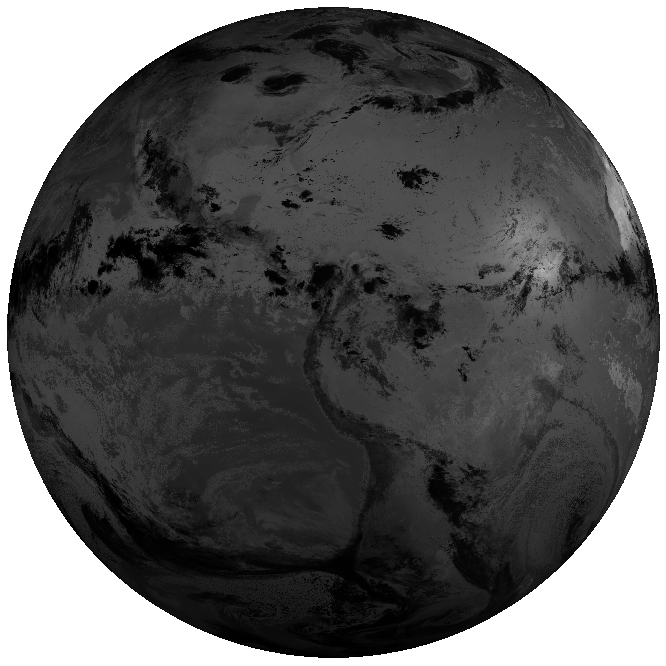

In [76]:
fig = plt.figure(figsize=(12, 12))
plt.imshow(DS.Rad, cmap='gray')
plt.axis('off')
plt.savefig(file_name + '.png', dpi=300, facecolor='w', edgecolor='w')

In [89]:
def make_prefix(product_name, year, day_of_year, hour, band):
    return (product_name+'/'+ str(year) + '/' + str(day_of_year).zfill(3) 
                                         + '/' + str(hour).zfill(2) + '/OR_'+ 
                                         product_name + '-M6C' + str(band).zfill(2))

def get_file_names(bucket_names, product_names, years, days_of_year, hours=None, bands=None, mode=6):
    if hours == None:
        hours = range(24)
    if bands == None:
        bands = range(1,17)
    values = product(bucket_names, product_names, years, days_of_year,hours,bands)
    keys = ['bucket_name', 'product_name', 'year', 'day_of_year', 'hour', 'band', 'mode']
    rows = [ dict(zip(keys,value)) for value in values]
    fnames = []
    for row in rows:
        prefix = make_prefix(row['product_name'], row['year'], row['day_of_year'], row['hour'], row['band'])
        keys = get_s3_keys(row['bucket_name'], prefix)
        fnames += list(keys)
    return fnames
print(list(get_file_names(['noaa-goes16','noaa-goes17'],['ABI-L1b-RadF'],[2019],[200,201],hours=[12,13],bands=[1,2])))
print('*'*16)
print(list(get_file_names(['noaa-goes16'],['ABI-L1b-RadF'],[2019],[200])))

#bucket_name = 'noaa-goes16'
#product_name = 'ABI-L1b-RadF'
#year = 2019
#day_of_year = 200
#hour = 12
#band = 7
#mode = 6

['ABI-L1b-RadF/2019/200/12/OR_ABI-L1b-RadF-M6C01_G16_s20192001200409_e20192001210117_c20192001210171.nc', 'ABI-L1b-RadF/2019/200/12/OR_ABI-L1b-RadF-M6C01_G16_s20192001210409_e20192001220117_c20192001220164.nc', 'ABI-L1b-RadF/2019/200/12/OR_ABI-L1b-RadF-M6C01_G16_s20192001220409_e20192001230117_c20192001230167.nc', 'ABI-L1b-RadF/2019/200/12/OR_ABI-L1b-RadF-M6C01_G16_s20192001230409_e20192001240117_c20192001240171.nc', 'ABI-L1b-RadF/2019/200/12/OR_ABI-L1b-RadF-M6C01_G16_s20192001240409_e20192001250117_c20192001250166.nc', 'ABI-L1b-RadF/2019/200/12/OR_ABI-L1b-RadF-M6C01_G16_s20192001250409_e20192001300117_c20192001300168.nc', 'ABI-L1b-RadF/2019/200/12/OR_ABI-L1b-RadF-M6C02_G16_s20192001200409_e20192001210117_c20192001210162.nc', 'ABI-L1b-RadF/2019/200/12/OR_ABI-L1b-RadF-M6C02_G16_s20192001210409_e20192001220117_c20192001220161.nc', 'ABI-L1b-RadF/2019/200/12/OR_ABI-L1b-RadF-M6C02_G16_s20192001220409_e20192001230117_c20192001230161.nc', 'ABI-L1b-RadF/2019/200/12/OR_ABI-L1b-RadF-M6C02_G16_s2

['ABI-L1b-RadF/2019/200/00/OR_ABI-L1b-RadF-M6C01_G16_s20192000000404_e20192000010112_c20192000010166.nc', 'ABI-L1b-RadF/2019/200/00/OR_ABI-L1b-RadF-M6C01_G16_s20192000010404_e20192000020112_c20192000020157.nc', 'ABI-L1b-RadF/2019/200/00/OR_ABI-L1b-RadF-M6C01_G16_s20192000020404_e20192000030112_c20192000030159.nc', 'ABI-L1b-RadF/2019/200/00/OR_ABI-L1b-RadF-M6C01_G16_s20192000030404_e20192000040112_c20192000040161.nc', 'ABI-L1b-RadF/2019/200/00/OR_ABI-L1b-RadF-M6C01_G16_s20192000040404_e20192000050112_c20192000050160.nc', 'ABI-L1b-RadF/2019/200/00/OR_ABI-L1b-RadF-M6C01_G16_s20192000050404_e20192000100112_c20192000100160.nc', 'ABI-L1b-RadF/2019/200/00/OR_ABI-L1b-RadF-M6C02_G16_s20192000000404_e20192000010112_c20192000010159.nc', 'ABI-L1b-RadF/2019/200/00/OR_ABI-L1b-RadF-M6C02_G16_s20192000010404_e20192000020112_c20192000020147.nc', 'ABI-L1b-RadF/2019/200/00/OR_ABI-L1b-RadF-M6C02_G16_s20192000020404_e20192000030112_c20192000030152.nc', 'ABI-L1b-RadF/2019/200/00/OR_ABI-L1b-RadF-M6C02_G16_s2

In [91]:
sample = list(get_file_names(['noaa-goes16','noaa-goes17'],['ABI-L1b-RadF'],[2019],[200],hours=[12],bands=[7]))

In [94]:
print('\n'.join(sample))

ABI-L1b-RadF/2019/200/12/OR_ABI-L1b-RadF-M6C07_G16_s20192001200409_e20192001210128_c20192001210168.nc
ABI-L1b-RadF/2019/200/12/OR_ABI-L1b-RadF-M6C07_G16_s20192001210409_e20192001220129_c20192001220168.nc
ABI-L1b-RadF/2019/200/12/OR_ABI-L1b-RadF-M6C07_G16_s20192001220409_e20192001230128_c20192001230167.nc
ABI-L1b-RadF/2019/200/12/OR_ABI-L1b-RadF-M6C07_G16_s20192001230409_e20192001240129_c20192001240166.nc
ABI-L1b-RadF/2019/200/12/OR_ABI-L1b-RadF-M6C07_G16_s20192001240409_e20192001250128_c20192001250169.nc
ABI-L1b-RadF/2019/200/12/OR_ABI-L1b-RadF-M6C07_G16_s20192001250409_e20192001300128_c20192001300168.nc
ABI-L1b-RadF/2019/200/12/OR_ABI-L1b-RadF-M6C07_G17_s20192001200341_e20192001209419_c20192001209454.nc
ABI-L1b-RadF/2019/200/12/OR_ABI-L1b-RadF-M6C07_G17_s20192001210341_e20192001219419_c20192001219454.nc
ABI-L1b-RadF/2019/200/12/OR_ABI-L1b-RadF-M6C07_G17_s20192001220341_e20192001229419_c20192001229452.nc
ABI-L1b-RadF/2019/200/12/OR_ABI-L1b-RadF-M6C07_G17_s20192001230341_e20192001239419